# ✅ Install dependencies

In [ ]:
%pip install tensorflow numpy mediapipe opencv-python tensorflowjs pyautogui matplotlib seaborn scikit-learn ipython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# ✅ Import library

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

# ✅ Deteksi tangan dengan MediaPipe

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# ✅ Ambil dan simpan data gesture

In [ ]:
DATA_DIR = "hand_data"
os.makedirs(DATA_DIR, exist_ok=True)
gestures = ["SS", "transfer_SS"]
num_samples = 600

cap = cv2.VideoCapture(0)

for gesture_name in gestures:
    print(f"Bersiap untuk merekam gesture: {gesture_name}")
    print("Tekan 's' untuk mulai merekam...")

    # Tunggu hingga user tekan 's'
    while True:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        cv2.putText(frame, f"Tekan 's' untuk rekam {gesture_name}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("Hand Tracking", frame)
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    print(f"Merekam {num_samples} sampel untuk gesture: {gesture_name}")
    data, labels = [], []
    i = 0

    while i < num_samples:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb_frame)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.append(lm.x)
                    landmarks.append(lm.y)
                    landmarks.append(lm.z)  # z untuk kedalaman
                data.append(landmarks)
                labels.append(gesture_name)  # ✅ Simpan label sebagai string, bukan angka
                i += 1

                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.putText(frame, f"Recording {gesture_name}: {i}/{num_samples}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.imshow("Hand Tracking", frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    np.save(os.path.join(DATA_DIR, f"{gesture_name}_data.npy"), np.array(data))
    np.save(os.path.join(DATA_DIR, f"{gesture_name}_labels.npy"), np.array(labels))  # ✅ Label tetap string
    print(f"Selesai merekam {gesture_name}! Data disimpan.")

cap.release()
cv2.destroyAllWindows()

Bersiap untuk merekam gesture: SS
Tekan 's' untuk mulai merekam...
Merekam 600 sampel untuk gesture: SS
Selesai merekam SS! Data disimpan.
Bersiap untuk merekam gesture: transfer_SS
Tekan 's' untuk mulai merekam...
Merekam 600 sampel untuk gesture: transfer_SS
Selesai merekam transfer_SS! Data disimpan.


In [3]:
# Load data masing-masing gestur dari file
data_ss = np.load("hand_data/SS_data.npy")          
data_tf = np.load("hand_data/transfer_SS_data.npy")  

# Fungsi untuk menampilkan 1 array fitur (frame ke-0) 
def tampilkan_vektor(data, nama):
    print(f"\n=== Gesture: {nama} ===")
    print("Vektor fitur (63 nilai):")
    print(data[0])  # Menampilkan array fitur frame pertama
    print("Jumlah fitur:", len(data[0]))

    print("\nKoordinat tiap titik (x, y, z):")
    for i in range(21):
        x = data[0][i*3]
        y = data[0][i*3 + 1]
        z = data[0][i*3 + 2]
        print(f"Titik {i+1:02d}: x={x:.3f}, y={y:.3f}, z={z:.3f}")

# Tampilkan untuk kedua gesture
tampilkan_vektor(data_ss, "SS (Screenshot)")
tampilkan_vektor(data_tf, "transfer_SS (Transfer File)")


=== Gesture: SS (Screenshot) ===
Vektor fitur (63 nilai):
[ 9.21671689e-01  8.28608155e-01  1.48671560e-07  8.59437406e-01
  8.11953485e-01 -2.14683786e-02  8.02134693e-01  7.64693022e-01
 -3.32777984e-02  7.56477356e-01  7.26188362e-01 -4.15811464e-02
  7.15011835e-01  6.92384064e-01 -4.77184579e-02  8.38938057e-01
  6.54418886e-01 -2.09479816e-02  8.00544441e-01  5.77601731e-01
 -3.57486606e-02  7.67147660e-01  5.54471672e-01 -4.74159233e-02
  7.37347424e-01  5.52250564e-01 -5.33325970e-02  8.69353235e-01
  6.41868174e-01 -1.67101938e-02  8.29026461e-01  5.64850807e-01
 -2.79522333e-02  7.88643956e-01  5.43233991e-01 -3.56983319e-02
  7.56331742e-01  5.42706072e-01 -4.05754708e-02  8.95188630e-01
  6.41974688e-01 -1.45122446e-02  8.58085692e-01  5.66883445e-01
 -2.42505055e-02  8.18255067e-01  5.43687999e-01 -2.73416899e-02
  7.86307812e-01  5.39888084e-01 -2.77555082e-02  9.16537762e-01
  6.46435559e-01 -1.37740374e-02  8.83593857e-01  5.84704876e-01
 -2.14853100e-02  8.50981534e-0

# ✅ Data augmentation functions

In [4]:
def add_jitter(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def flip_horizontal(data):
    data_flipped = data.copy()
    data_flipped[:, ::2] = 1 - data_flipped[:, ::2]
    return data_flipped

def scale(data, scale_range=(0.9, 1.1)):
    factor = np.random.uniform(*scale_range)
    return data * factor

def translate(data, shift_range=0.05):
    shift_x = np.random.uniform(-shift_range, shift_range)
    shift_y = np.random.uniform(-shift_range, shift_range)
    data_translated = data.copy()
    data_translated[:, ::2] += shift_x
    data_translated[:, 1::2] += shift_y
    return data_translated

# ✅ Dataset loader + augment

In [5]:
DATA_DIR = "hand_data"
data_files = [f for f in os.listdir(DATA_DIR) if "data.npy" in f]
label_files = [f for f in os.listdir(DATA_DIR) if "labels.npy" in f]

X, y = [], []
for file in data_files:
    X.append(np.load(os.path.join(DATA_DIR, file)))
for file in label_files:
    y.append(np.load(os.path.join(DATA_DIR, file)))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# ✅ Apply augmentation

In [6]:
def augment_dataset(X, y, augment_factor=2):
    X_augmented, y_augmented = [], []
    for i in range(len(X)):
        X_augmented.append(X[i])
        y_augmented.append(y[i])
        for _ in range(augment_factor):
            method = np.random.choice(['jitter', 'flip', 'scale', 'translate'])
            if method == 'jitter':
                X_aug = add_jitter(X[i].reshape(1, -1))
            elif method == 'flip':
                X_aug = flip_horizontal(X[i].reshape(1, -1))
            elif method == 'scale':
                X_aug = scale(X[i].reshape(1, -1))
            elif method == 'translate':
                X_aug = translate(X[i].reshape(1, -1))
            X_augmented.append(X_aug[0])
            y_augmented.append(y[i])
    return np.array(X_augmented), np.array(y_augmented)

X, y = augment_dataset(X, y)
print("Data after augmentation:", X.shape)

Data after augmentation: (3603, 63)


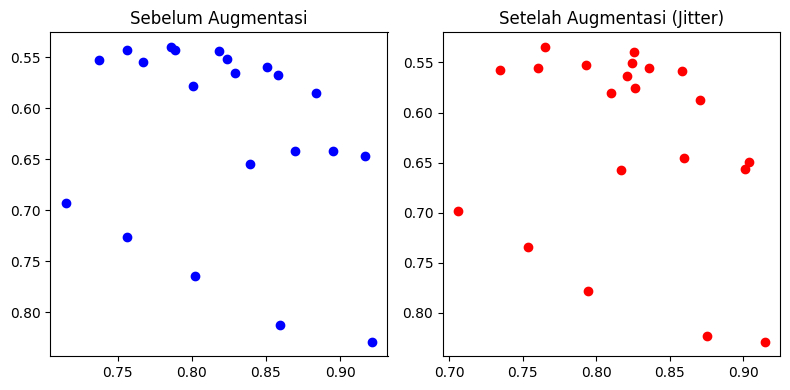

In [7]:
# Visualisasi hasil augmentasi
sample = X[0].reshape(-1)  # 63 elemen -> 21 titik x y z
x = sample[0::3]
y = sample[1::3]

# Augmentasi (misalnya jitter atau translate)
sample_aug = add_jitter(sample.reshape(1, -1)).reshape(-1)
x_aug = sample_aug[0::3]
y_aug = sample_aug[1::3]

# Plot hasilnya
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c='blue')
plt.title("Sebelum Augmentasi")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.scatter(x_aug, y_aug, c='red')
plt.title("Setelah Augmentasi (Jitter)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# ✅ Load dan preprocessing data, Encode labels and reshape input

In [8]:
data_files = [f for f in os.listdir(DATA_DIR) if "data.npy" in f]
label_files = [f for f in os.listdir(DATA_DIR) if "labels.npy" in f]

X, y = [], []
for file in data_files:
    X.append(np.load(os.path.join(DATA_DIR, file)))
for file in label_files:
    y.append(np.load(os.path.join(DATA_DIR, file)))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

le = LabelEncoder()
y = le.fit_transform(y)
X = X.reshape(X.shape[0], 1, X.shape[1])

# ✅ Split data + model training + validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(1, X.shape[2])),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))




Epoch 1/30


60/60 [==============================] - 3s 8ms/step - loss: 0.6933 - accuracy: 0.4896 - val_loss: 0.6911 - val_accuracy: 0.6141
Epoch 2/30
60/60 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.6958 - val_loss: 0.5453 - val_accuracy: 0.9004
Epoch 3/30
60/60 [==============================] - 0s 2ms/step - loss: 0.3508 - accuracy: 0.8969 - val_loss: 0.2142 - val_accuracy: 0.9253
Epoch 4/30
60/60 [==============================] - 0s 2ms/step - loss: 0.1956 - accuracy: 0.9260 - val_loss: 0.1420 - val_accuracy: 0.9502
Epoch 5/30
60/60 [==============================] - 0s 2ms/step - loss: 0.2053 - accuracy: 0.9135 - val_loss: 0.1486 - val_accuracy: 0.9668
Epoch 6/30
60/60 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.9281 - val_loss: 0.1010 - val_accuracy: 0.9668
Epoch 7/30
60/60 [==============================] - 0s 3ms/step - loss: 0.1387 - accuracy: 0.9427 - val_loss: 0.0884 - val_accuracy: 0.9710
Epoch 8/30
60/60

# ✅ Plot accuracy dan loss

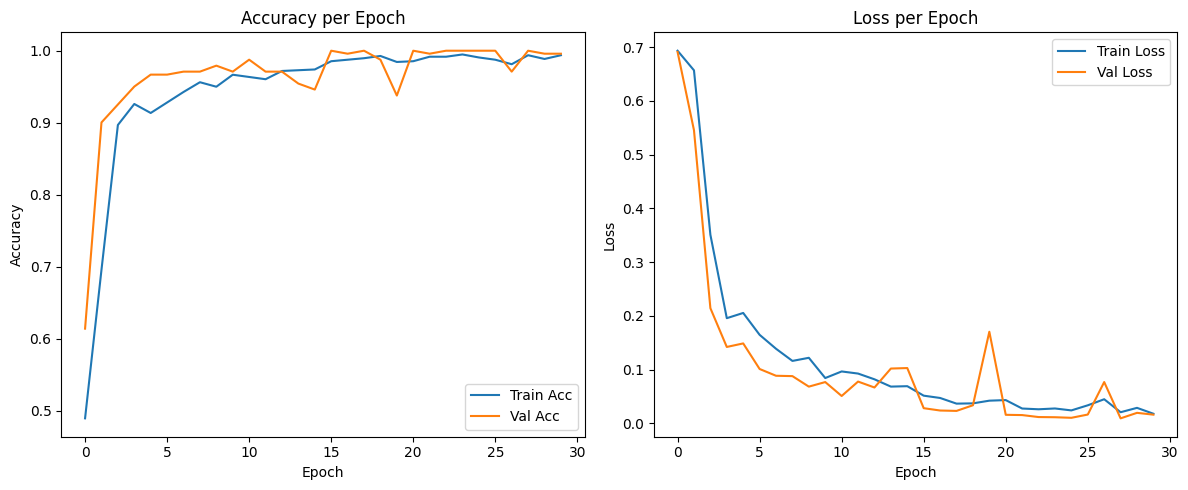

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# ✅ Confusion matrix dan evaluasi model

8/8 [==============================] - 0s 3ms/step


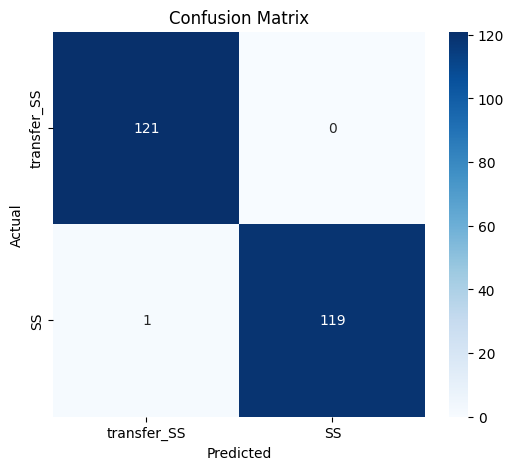

Accuracy: 99.59%
Precision: 99.59%
Recall: 99.59%
F1-score: 99.59%


In [17]:
# Prediksi kelas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Urutan label yang diinginkan: transfer_SS dulu, lalu SS
label_order = ['transfer_SS', 'SS']

# Ambil indeks label sesuai urutan di LabelEncoder
label_indices = [np.where(le.classes_ == label)[0][0] for label in label_order]

# Hitung confusion matrix dengan urutan label yang diatur
cm = confusion_matrix(y_test, y_pred_classes, labels=label_indices)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order, yticklabels=label_order)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Hitung classification report dengan label terurut
report = classification_report(y_test, y_pred_classes,
                               labels=label_indices,
                               target_names=label_order,
                               output_dict=True)

# Ambil metrik-metrik utama
accuracy = report['accuracy'] * 100
precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1 = report['weighted avg']['f1-score'] * 100

# Cetak hasil evaluasi
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-score: {f1:.2f}%")

# ✅ Tampilkan metrik dalam format besar HTML

In [18]:
html = f"""
<h3><strong>Accuracy:</strong> {accuracy:.2f}%</h3>
<h3><strong>Precision:</strong> {precision:.2f}%</h3>
<h3><strong>Recall:</strong> {recall:.2f}%</h3>
<h3><strong>F1-score:</strong> {f1:.2f}%</h3>
"""
display(HTML(html))

# ✅ Simpan model

In [13]:
model.save("hand_gesture_model.h5")

d:\Tugas Akhir\Program\jupyter-hands-recognition\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ✅ Real-time prediksi gesture via webcam

In [14]:
model = tf.keras.models.load_model("hand_gesture_model.h5")
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.append(lm.x)
                landmarks.append(lm.y)
                landmarks.append(lm.z)
            landmarks = np.array(landmarks).reshape(1, 1, -1)
            prediction = model.predict(landmarks)
            class_index = np.argmax(prediction)
            class_label = le.inverse_transform([class_index])[0]
            cv2.putText(frame, class_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    cv2.imshow("Hand Gesture Recognition", frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 6ms/step
